In [2]:
import time
from collections import deque
from typing import Any

import os

os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import gym
import logging
from arguments import get_args
from env import make_vec_envs
from utils.storage import GlobalRolloutStorage, FIFOMemory
from utils.optimization import get_optimizer
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module

from ppo import PPO

import sys
import matplotlib

if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt

from env import get_local_map_boundaries
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensor

In [3]:
argumnts = ''
args = get_args(argumnts)

args.num_processes = 1


np.random.seed(args.seed)
torch.manual_seed(args.seed)

if args.cuda:
    torch.cuda.manual_seed(args.seed)

Auto GPU config:
Number of processes: 36
Number of processes on GPU 0: 4
Number of processes per GPU: 16


In [4]:
log_dir = "{}models/{}/".format(args.dump_location, args.exp_name)
dump_dir = "{}dump/{}/".format(args.dump_location, args.exp_name)
if not os.path.exists(log_dir):
        os.makedirs(log_dir)
if not os.path.exists("{}/images/".format(dump_dir)):
    os.makedirs("{}/images/".format(dump_dir))

In [5]:
logging.basicConfig(
        filename=log_dir + 'train.log',
        level=logging.INFO)
print("Dumping at {}".format(log_dir))
print(args)
args.env_frame_height = 480
args.env_frame_width = 640

args.frame_height = 480
args.frame_width = 640

logging.info(args)


Dumping at ./tmp/models/exp1/
Namespace(alpha=0.99, auto_gpu_config=1, camera_height=1.25, clip_param=0.2, collision_threshold=0.2, cuda=True, du_scale=2, dump_location='./tmp/', entropy_coef=0.001, env_frame_height=256, env_frame_width=256, eps=1e-05, eval=0, exp_loss_coeff=1.0, exp_name='exp1', frame_height=128, frame_width=128, gamma=0.99, global_downscaling=2, global_hidden_size=256, global_lr=2.5e-05, goals_size=2, hfov=90.0, load_global='0', load_local='0', load_slam='0', local_hidden_size=512, local_optimizer='adam,lr=0.0001', local_policy_update_freq=5, log_interval=10, map_pred_threshold=0.5, map_resolution=5, map_size_cm=2400, max_episode_length=1000, max_grad_norm=0.5, no_cuda=False, noise_level=1.0, noisy_actions=1, noisy_odometry=1, num_episodes=1000000, num_global_steps=40, num_local_steps=25, num_mini_batch=18, num_processes=1, num_processes_on_first_gpu=4, num_processes_per_gpu=16, obs_threshold=1, obstacle_boundary=5, pose_loss_coeff=10000.0, ppo_epoch=4, pretrained_re

In [6]:
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
policy_loss = 0

best_cost = 100000
costs = deque(maxlen=1000)
exp_costs = deque(maxlen=1000)
sem_costs = deque(maxlen=1000)
pose_costs = deque(maxlen=1000)

g_masks = torch.ones(num_scenes).float().to(device)
l_masks = torch.zeros(num_scenes).float().to(device)

best_local_loss = np.inf
best_g_reward = -np.inf

if args.eval:
    traj_lengths = args.max_episode_length // args.num_local_steps
    explored_area_log = np.zeros((num_scenes, num_episodes, traj_lengths))
    explored_ratio_log = np.zeros((num_scenes, num_episodes, traj_lengths))

g_episode_rewards = deque(maxlen=1000)

l_action_losses = deque(maxlen=1000)

g_value_losses = deque(maxlen=1000)
g_action_losses = deque(maxlen=1000)
g_dist_entropies = deque(maxlen=1000)

per_step_g_rewards = deque(maxlen=1000)

g_process_rewards = np.zeros((num_scenes))

# One env

In [6]:
from habitat.datasets.object_nav.object_nav_dataset import ObjectNavDatasetV1

from vec_env import init_config
i = 0
basic_config = init_config()
basic_config.defrost()
basic_config.DATASET.SPLIT = args.split
basic_config.freeze()
scenes = ObjectNavDatasetV1.get_scenes_to_load(basic_config.DATASET)
scene_split_size = int(np.floor(len(scenes) / args.num_processes))

config_env = init_config()
config_env.defrost()     
if len(scenes) > 0:
    config_env.DATASET.CONTENT_SCENES = scenes[i * scene_split_size: (i + 1) * scene_split_size]
if i < args.num_processes_on_first_gpu:
    gpu_id = 0
else:
    gpu_id = int((i - args.num_processes_on_first_gpu)
                 // args.num_processes_per_gpu) + args.sim_gpu_id
gpu_id = min(torch.cuda.device_count() - 1, gpu_id)
config_env.SIMULATOR.HABITAT_SIM_V0.GPU_DEVICE_ID = gpu_id
agent_sensors = []
agent_sensors.append("RGB_SENSOR")
agent_sensors.append("DEPTH_SENSOR")
config_env.SIMULATOR.AGENT_0.SENSORS = agent_sensors
config_env.ENVIRONMENT.MAX_EPISODE_STEPS = args.max_episode_length
config_env.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE = False
config_env.SIMULATOR.RGB_SENSOR.WIDTH = args.env_frame_width
config_env.SIMULATOR.RGB_SENSOR.HEIGHT = args.env_frame_height
config_env.SIMULATOR.RGB_SENSOR.HFOV = args.hfov
config_env.SIMULATOR.RGB_SENSOR.POSITION = [0, args.camera_height, 0]
config_env.SIMULATOR.DEPTH_SENSOR.WIDTH = args.env_frame_width
config_env.SIMULATOR.DEPTH_SENSOR.HEIGHT = args.env_frame_height
config_env.SIMULATOR.DEPTH_SENSOR.HFOV = args.hfov
config_env.SIMULATOR.DEPTH_SENSOR.POSITION = [0, args.camera_height, 0]
config_env.SIMULATOR.TURN_ANGLE = 10
config_env.DATASET.SPLIT = 'val_mini'
config_env.DATASET.CONTENT_SCENES = ['*']

config_env.TASK.COMPASS_SENSOR.GOAL_FORMAT = 'EULER'
config_env.TASK.COMPASS_SENSOR.DIMENSIONALITY = 3

config_env.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config_env.TASK.SENSORS.append("HEADING_SENSOR")
config_env.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')



# config_env.DATASET.DATA_PATH = '/data/data/datasets/pointnav/habitat-test-scenes/v1/{split}/{split}.json.gz'
# config_env.DATASET.SCENES_DIR = '/data/data/scene_datasets/'

config_env.DATASET.SCENES_DIR = '/data/data/matterport_dataset/v1/tasks'
config_env.DATASET.DATA_PATH = '/data/data/matterport_dataset/v1/tasks/mp3d-tasks/{split}/{split}.json.gz'

# print(config_env.TASK.POINTGOAL_SENSOR)

config_env.TASK.MEASUREMENTS = ['DISTANCE_TO_GOAL', 'SPL', 'TOP_DOWN_MAP']


print(config_env.DATASET)

# print(config_env.DATASET)


# config_env.DA
config_env.freeze()

config_baseline = init_config()

from habitat.datasets.object_nav.object_nav_dataset import ObjectNavDatasetV1
dataset = ObjectNavDatasetV1(config_env.DATASET)
config_env.defrost()
config_env.SIMULATOR.SCENE = dataset.episodes[0].scene_id
print("Loading {}".format(config_env.SIMULATOR.SCENE))
config_env.freeze()
rank = range(args.num_processes)

CONTENT_SCENES: ['*']
DATA_PATH: /data/data/matterport_dataset/v1/tasks/mp3d-tasks/{split}/{split}.json.gz
SCENES_DIR: /data/data/matterport_dataset/v1/tasks
SPLIT: val_mini
TYPE: ObjectNav-v1
Loading /data/data/matterport_dataset/v1/tasks/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.glb


In [7]:
print(config_env)

DATASET:
  CONTENT_SCENES: ['*']
  DATA_PATH: /data/data/matterport_dataset/v1/tasks/mp3d-tasks/{split}/{split}.json.gz
  SCENES_DIR: /data/data/matterport_dataset/v1/tasks
  SPLIT: val_mini
  TYPE: ObjectNav-v1
ENVIRONMENT:
  ITERATOR_OPTIONS:
    CYCLE: True
    GROUP_BY_SCENE: True
    MAX_SCENE_REPEAT_EPISODES: -1
    MAX_SCENE_REPEAT_STEPS: 10000
    NUM_EPISODE_SAMPLE: -1
    SHUFFLE: False
    STEP_REPETITION_RANGE: 0.2
  MAX_EPISODE_SECONDS: 10000000
  MAX_EPISODE_STEPS: 1000
PYROBOT:
  BASE_CONTROLLER: proportional
  BASE_PLANNER: none
  BUMP_SENSOR:
    TYPE: PyRobotBumpSensor
  DEPTH_SENSOR:
    CENTER_CROP: False
    HEIGHT: 480
    MAX_DEPTH: 5.0
    MIN_DEPTH: 0.0
    NORMALIZE_DEPTH: True
    TYPE: PyRobotDepthSensor
    WIDTH: 640
  LOCOBOT:
    ACTIONS: ['BASE_ACTIONS', 'CAMERA_ACTIONS']
    BASE_ACTIONS: ['go_to_relative', 'go_to_absolute']
    CAMERA_ACTIONS: ['set_pan', 'set_tilt', 'set_pan_tilt']
  RGB_SENSOR:
    CENTER_CROP: False
    HEIGHT: 480
    TYPE: PyRobo

In [8]:
def draw():
    mapper_gt_pose = (one_env.curr_loc_gt[0]*100.0,
                      one_env.curr_loc_gt[1]*100.0,
                      np.deg2rad(one_env.curr_loc_gt[2]))
    
    print(mapper_gt_pose)

    circ = Circle((mapper_gt_pose[0]/args.map_size_cm*500,mapper_gt_pose[1]/args.map_size_cm*500),3,color='white')
    circ2 = Circle((mapper_gt_pose[0]/args.map_size_cm*500,mapper_gt_pose[1]/args.map_size_cm*500),3,color='white')
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(231)
    ax2 = f.add_subplot(232)
    ax3 = f.add_subplot(233)
    #ax4 = f.add_subplot(234)
    #ax5 = f.add_subplot(235)
    ax.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    #ax4.set_aspect('equal')
    #ax5.set_aspect('equal')
    ax.add_patch(circ)
    ax2.add_patch(circ2)
    ax.imshow(one_env.map)
    ax.set_title('map')
    ax2.imshow(one_env.explored_map)
    ax2.set_title('explored_map ')
    ax2.imshow(one_env.semantic_map)
    ax2.set_title('semantic_map ')
    ax3.imshow(np.transpose(obs, (1,2,0)))
    #ax4.imshow(info['fp_explored'])
    #ax4.set_title('fp_explored ')
    #ax5.imshow(info['fp_proj'])
    #ax5.set_title('fp_proj ')

In [9]:
from habitat_baselines.common.environments import get_env_class

env_class = get_env_class("Exploration_Env")

one_env = env_class(args=args, rank=rank,
                          config_env=config_env, config_baseline=config_baseline, dataset=dataset)

2020-05-04 15:20:33,063 initializing sim Sim-v0
2020-05-04 15:20:38,675 Initializing task ObjectNav-v1


In [ ]:
print(full_obs['gps'])
print(full_obs['compass'])
print(full_obs.keys())

In [3]:
import quaternion

agent_state = one_env._env.sim.get_agent_state(0)
x = -agent_state.position[2]
y = -agent_state.position[0]
axis = quaternion.as_euler_angles(agent_state.rotation)[0]
if (axis%(2*np.pi)) < 0.1 or (axis%(2*np.pi)) > 2*np.pi - 0.1:
    o = quaternion.as_euler_angles(agent_state.rotation)[1]
else:
    o = 2*np.pi - quaternion.as_euler_angles(agent_state.rotation)[1]
if o > np.pi:
    o -= 2 * np.pi

print(x, y, o)

NameError: name 'one_env' is not defined

In [4]:
agent_state = full_obs['gps']

x = agent_state[0]
y = agent_state[1]

full_obs['compass']

NameError: name 'full_obs' is not defined

In [5]:
c1 = full_obs['compass'][0]
c2 = -2.9895056012562216

NameError: name 'full_obs' is not defined

In [36]:
c3 = full_obs['compass'][0]
c4 = o

In [37]:
print(c3 - c1)
print(c4 - c2)

0.17453295
0.1745329335565846


In [10]:
obs, infos, full_obs = one_env.reset()
print(one_env.curr_loc)
print(args.map_size_cm)

2020-05-04 15:20:40,968 Computing map for /data/data/matterport_dataset/v1/tasks/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.glb


[12.0, 12.0, 0.0]
2400


/opt/conda/envs/habitat/lib/python3.6/site-packages/torch-1.4.0-py3.6-linux-x86_64.egg/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch-1.4.0-py3.6-linux-x86_64.egg/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [11]:
import habitat.utils.visualizations.maps as kek

In [12]:
from habitat.utils.visualizations import maps
from habitat.core.utils import try_cv2_import

cv2 = try_cv2_import()

def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        info["top_down_map"]["map"], info["top_down_map"]["fog_of_war_mask"]
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
#     top_down_map = maps.draw_agent(
#         top_down_map,
#         map_agent_pos,
#         heading - np.pi / 2,
#         agent_radius_px=top_down_map.shape[0] / 40,
#     )
    return top_down_map

In [16]:
m = draw_top_down_map(full_info, full_obs['heading'], 480)

plt.imshow(m)

NameError: name 'full_info' is not defined

In [ ]:
n = full_info['top_down_map']['map']

print(n == 9) 

plt.imshow(n == 6)

In [17]:
print(full_obs.keys())

scene = one_env._env._sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])

dict_keys(['rgb', 'depth', 'semantic', 'objectgoal', 'compass', 'gps', 'heading'])


In [20]:
scene = one_env._env._sim.semantic_annotations()
index_to_title_map = {obj.category.index(): obj.category.name() for obj in scene.objects }
index_to_title_map[-1] = 'nope'

In [19]:
one_env._env.current_episode.goals[0].object_category

'towel'

In [19]:
one_env._env._sim.semantic_annotations().objects[1].category.index()

40

In [20]:
plt.imshow(np.take(mapping, full_obs['semantic']))

lalka = dict()

for line in np.take(mapping, full_obs['semantic']):
    for el in line:
        if index_to_title_map[el] in lalka:
            lalka[index_to_title_map[el]] += 1
        else:
            lalka[index_to_title_map[el]] = 1 

print(lalka)

NameError: name 'mapping' is not defined

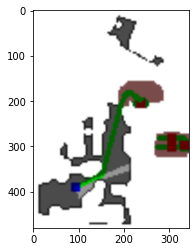

(1202.5000194521067, 1200.0000043368675, 0.0)


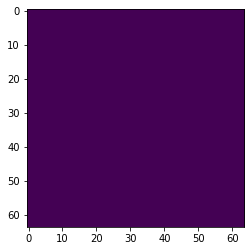

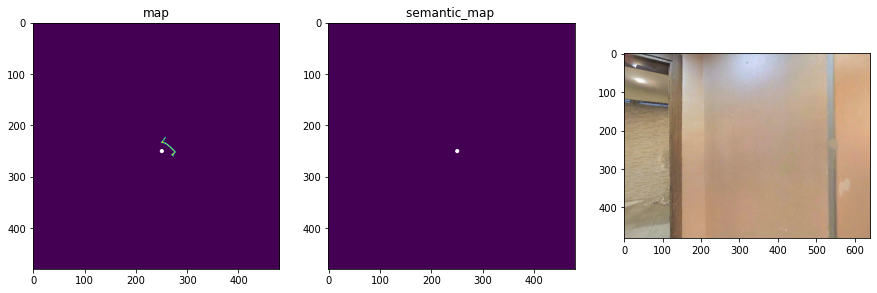

In [13]:
actions = ['TURN_RIGHT', 'TURN_LEFT', 'MOVE_FORWARD']

for i in range(1):
    obs, reward, done, info, full_obs, full_info = one_env.step('MOVE_FORWARD')
m = draw_top_down_map(full_info, full_obs['heading'], 480)
plt.imshow(m)
plt.show()
plt.imshow(info['semantic_fp_proj'])
# plt.imshow(kek.get_topdown_map(one_env._env._sim))
draw()

In [45]:
kek = np.take(mapping, full_obs['semantic'])
g = one_env._env.current_episode.goals[0].object_category

print(kek.shape)

((kek == objectgoal_mapping[g]) * full_obs['depth'][:,:,0])[51]

(480, 640)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
scene = one_env._env._sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
        
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])
objectgoal_mapping = {obj.category.name(): obj.category.index() for obj in scene.objects }

# Multiple env

In [7]:
def init_map_and_pose():
    full_map.fill_(0.)
    full_pose.fill_(0.)
    full_pose[:, :2] = args.map_size_cm / 100.0 / 2.0

    locs = full_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        full_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.0

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

    for e in range(num_scenes):
        local_map[e] = full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

In [8]:
torch.set_num_threads(1)
envs = make_vec_envs(args)
obs, info, full_obs = envs.reset()

56


In [9]:
kek = envs.step(torch.Tensor([0]))

In [10]:
args

Namespace(alpha=0.99, auto_gpu_config=1, camera_height=1.25, clip_param=0.2, collision_threshold=0.2, cuda=True, device=device(type='cuda', index=0), du_scale=2, dump_location='./tmp/', entropy_coef=0.001, env_frame_height=480, env_frame_width=640, eps=1e-05, eval=0, exp_loss_coeff=1.0, exp_name='exp1', frame_height=480, frame_width=640, gamma=0.99, global_downscaling=2, global_hidden_size=256, global_lr=2.5e-05, goals_size=2, hfov=90.0, load_global='0', load_local='0', load_slam='0', local_hidden_size=512, local_optimizer='adam,lr=0.0001', local_policy_update_freq=5, log_interval=10, map_pred_threshold=0.5, map_resolution=5, map_size_cm=2400, max_episode_length=1000, max_grad_norm=0.5, no_cuda=False, noise_level=1.0, noisy_actions=1, noisy_odometry=1, num_episodes=1000000, num_global_steps=40, num_local_steps=25, num_mini_batch=18, num_processes=1, num_processes_on_first_gpu=4, num_processes_per_gpu=16, obs_threshold=1, obstacle_boundary=5, pose_loss_coeff=10000.0, ppo_epoch=4, pretra

In [11]:
torch.set_grad_enabled(False)
map_size = args.map_size_cm // args.map_resolution
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)

# Initializing full and local map
full_map = torch.zeros(num_scenes, 5, full_w, full_h).float().to(device)
local_map = torch.zeros(num_scenes, 5, local_w, local_h).float()

# Initial full and local pose
full_pose = torch.zeros(num_scenes, 3).float().to(device)
local_pose = torch.zeros(num_scenes, 3)

# Origin of local map
origins = np.zeros((num_scenes, 3))

# Local Map Boundaries
lmb = np.zeros((num_scenes, 4)).astype(int)
### Planner pose inputs has 7 dimensions
### 1-3 store continuous global agent location
### 4-7 store local map boundaries
planner_pose_inputs = np.zeros((num_scenes, 7))

In [12]:
init_map_and_pose()

In [13]:
# Global policy observation space
g_observation_space = gym.spaces.Box(0, 1,
                                     (10, #8,
                                      local_w,
                                      local_h), dtype='uint8')
# Global policy action space
g_action_space = gym.spaces.Box(low=0.0, high=1.0,
                                shape=(2,), dtype=np.float32)
# Local policy observation space
l_observation_space = gym.spaces.Box(0, 255,
                                     (3,
                                      args.frame_width,
                                      args.frame_height), dtype='uint8')
# Local and Global policy recurrent layer sizes
l_hidden_size = args.local_hidden_size
g_hidden_size = args.global_hidden_size

In [14]:
# slam
nslam_module = Neural_SLAM_Module(args, full_obs)
# slam_optimizer = get_optimizer(nslam_module.parameters(),
#                                args.slam_optimizer)

In [15]:
# Global policy
g_policy = RL_Policy(g_observation_space.shape, g_action_space,
                     base_kwargs={'recurrent': args.use_recurrent_global,
                                  'hidden_size': g_hidden_size,
                                  'downscaling': args.global_downscaling
                                  }).to(device)
g_agent = PPO(g_policy, args.clip_param, args.ppo_epoch,
                   args.num_mini_batch, args.value_loss_coef,
                   args.entropy_coef, lr=args.global_lr, eps=args.eps,
                   max_grad_norm=args.max_grad_norm)

# Local policy
# l_policy = Local_IL_Policy(l_observation_space.shape, envs.action_space[0].n,
#                            recurrent=args.use_recurrent_local,
#                            hidden_size=l_hidden_size,
#                            deterministic=args.use_deterministic_local).to(device)


l_policy = Local_IL_Policy(l_observation_space.shape, envs.action_space[0].n,
                           recurrent=args.use_recurrent_local,
                           hidden_size=l_hidden_size,
                           deterministic=args.use_deterministic_local).to(device)


local_optimizer = get_optimizer(l_policy.parameters(),
                                args.local_optimizer)

640 480


In [16]:
# Storage
g_rollouts = GlobalRolloutStorage(args.num_global_steps,
                                  num_scenes, g_observation_space.shape,
                                  g_action_space, g_policy.rec_state_size,
                                  1).to(device)

slam_memory = FIFOMemory(args.slam_memory_size)

In [17]:
# # Loading model
# if args.load_slam != "0":
#     print("Loading slam {}".format(args.load_slam))
#     state_dict = torch.load(args.load_slam,
#                             map_location=lambda storage, loc: storage)
#     nslam_module.load_state_dict(state_dict)

# if not args.train_slam:
#     nslam_module.eval()

if args.load_global != "0":
    print("Loading global {}".format(args.load_global))
    state_dict = torch.load(args.load_global,
                            map_location=lambda storage, loc: storage)
    g_policy.load_state_dict(state_dict)

if not args.train_global:
    g_policy.eval()

if args.load_local != "0":
    print("Loading local {}".format(args.load_local))
    state_dict = torch.load(args.load_local,
                            map_location=lambda storage, loc: storage)
    l_policy.load_state_dict(state_dict)

if not args.train_local:
    l_policy.eval()

In [18]:
obs, infos, full_obs = envs.reset()

In [19]:
%reload_ext autoreload
%autoreload 2

In [20]:
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module

In [21]:
nslam_module(full_obs)[0].shape

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
(1, 480, 480)


torch.Size([1, 480, 480])

In [22]:
# Predict map from frame 1:
# poses = torch.from_numpy(np.asarray(
#     [infos[env_idx]['sensor_pose'] for env_idx
#      in range(num_scenes)])
# ).float().to(device)

# _, _, local_map[:, 0, :, :], local_map[:, 1, :, :], local_map[:, 2, :, :], _, local_pose = \
#     nslam_module(obs, obs, poses, local_map[:, 0, :, :],
#                  local_map[:, 1, :, :], local_pose, semantic_obs, semantic_obs)

full_map[:, 0, :, :], full_map[:, 1, :, :], full_map[:, 2, :, :], local_pose = nslam_module(full_obs)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
(1, 480, 480)


In [23]:
local_map.shape

torch.Size([1, 5, 240, 240])

In [24]:
print(local_pose)

tensor([[0., 0., 0.]])


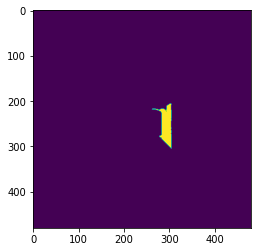

In [25]:
plt.imshow(full_map[0][1].cpu().numpy())

In [26]:
# Compute Global policy input
locs = local_pose.cpu().numpy()
global_input = torch.zeros(num_scenes, 10, local_w, local_h)
global_orientation = torch.zeros(num_scenes, 1).long()

for e in range(num_scenes):
    r, c = locs[e, 1], locs[e, 0]
    loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                    int(c * 100.0 / args.map_resolution)]

    local_map[e, 3:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
    global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)

global_input[:, 0:5, :, :] = local_map.detach()
global_input[:, 5:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map)

g_rollouts.obs[0].copy_(global_input)
g_rollouts.extras[0].copy_(global_orientation)


tensor([[36]], device='cuda:0')

In [27]:
g_rollouts.obs.shape

torch.Size([41, 1, 10, 240, 240])

In [28]:
# Run Global Policy (global_goals = Long-Term Goal)
g_value, g_action, g_action_log_prob, g_rec_states = \
    g_policy.act(
        g_rollouts.obs[0],
        g_rollouts.rec_states[0],
        g_rollouts.masks[0],
        extras=g_rollouts.extras[0],
        deterministic=False)

cpu_actions = nn.Sigmoid()(g_action).cpu().numpy()
global_goals = [[int(action[0] * local_w), int(action[1] * local_h)]
                for action in cpu_actions]

In [29]:
num_scenes

1

In [30]:
semantic_obs = [obs['semantic'] for obs in full_obs]

In [31]:
# Compute planner inputs
planner_inputs = [{} for e in range(num_scenes)]
for e, p_input in enumerate(planner_inputs):
    p_input['goal'] = global_goals[e]
    p_input['map_pred'] = global_input[e, 0, :, :].detach().cpu().numpy()
    p_input['exp_pred'] = global_input[e, 1, :, :].detach().cpu().numpy()
    p_input['sem_pred'] = global_input[e, 2, :, :].detach().cpu().numpy()
    p_input['pose_pred'] = planner_pose_inputs[e]
    

# Output stores local goals as well as the the ground-truth action
output = envs.get_short_term_goal(planner_inputs)

# last_obs = obs.detach()
last_obs = obs
local_rec_states = torch.zeros(num_scenes, l_hidden_size).to(device)
start = time.time()

total_num_steps = -1
g_reward = 0

torch.set_grad_enabled(False)

In [32]:
print(obs.detach())

tensor([[[[176., 175., 175.,  ..., 130., 130., 130.],
          [173., 176., 176.,  ..., 130., 130., 130.],
          [175., 179., 179.,  ..., 130., 130., 130.],
          ...,
          [145., 147., 147.,  ..., 147., 147., 151.],
          [145., 151., 151.,  ..., 147., 147., 151.],
          [157., 157., 151.,  ..., 151., 151., 151.]],

         [[176., 175., 175.,  ..., 130., 130., 130.],
          [173., 176., 176.,  ..., 130., 130., 130.],
          [175., 179., 179.,  ..., 130., 130., 130.],
          ...,
          [145., 147., 147.,  ..., 147., 147., 151.],
          [145., 151., 151.,  ..., 147., 147., 151.],
          [157., 157., 151.,  ..., 151., 151., 151.]],

         [[160., 159., 159.,  ..., 237., 237., 237.],
          [157., 160., 160.,  ..., 237., 237., 237.],
          [158., 154., 154.,  ..., 237., 237., 237.],
          ...,
          [145., 147., 147.,  ..., 229., 229., 233.],
          [145., 151., 151.,  ..., 229., 229., 233.],
          [157., 157., 151.,  ...

In [28]:
scene = envs.venv._sim.semantic_annotations()
instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
        
mapping = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])
objectgoal_mapping = {obj.category.name(): obj.category.index() for obj in scene.objects }

AttributeError: 'VectorEnv' object has no attribute '_sim'

In [ ]:
one_env._env._sim.semantic_annotations().objects[0].category

In [27]:
def prepare_sem_obs(observations):
    depth = observations['depth']
    semantic = observations['semantic']
    
    prepared_semantic = np.take(mapping, semantic)
    
    semantic_goal = one_env.current_episode.goals[0].object_category
    
    prepared_semantic = (prepared_semantic == objectgoal_mapping[semantic_goal])
    
    semantic_depth = depth[:,:,0] * prepared_semantic
        
    semantic_depth[semantic_depth == 0] = np.NaN
    
    return semantic_depth

In [28]:
sem_obs = prepare_sem_obs(full_obs)

In [17]:
print(output)

NameError: name 'output' is not defined

In [30]:
num_episodes = envs.num_envs
num_episodes

1

In [31]:
args.max_episode_length = 1

In [63]:
l_observation_space.shape

(3, 640, 640)

In [68]:
%reload_ext autoreload
%autoreload 2

from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module

l_policy = Local_IL_Policy(l_observation_space.shape, envs.action_space[0].n,
                           recurrent=args.use_recurrent_local,
                           hidden_size=l_hidden_size,
                           deterministic=args.use_deterministic_local).to(device)

640 480


In [88]:
envs.reset()

BrokenPipeError: [Errno 32] Broken pipe

array([[ 5.98084898,  5.99999877, -0.0160699 ]])

In [33]:
for ep_num in range(num_episodes):
    for step in range(args.max_episode_length):
        total_num_steps += 1
        
        g_step = (step // args.num_local_steps) % args.num_global_steps
        eval_g_step = step // args.num_local_steps + 1
        l_step = step % args.num_local_steps
        
        local_masks = l_masks
        
        local_goals = output[:, :-1].to(device).long()
        
        if args.train_local:
            torch.set_grad_enabled(True)
            
        action, action_prob, local_rec_states = l_policy(obs, local_rec_states, local_masks, extras=local_goals)
        
        if args.train_local:
            action_target = output[:, -1].long().to(device)
            policy_loss += nn.CrossEntropyLoss()(action_prob, action_target)
            torch.set_grad_enabled(False)
        l_action = action.cpu()
        
        print(l_action)
        
        obs, rew, done, infos, full_obs, _ = envs.step(l_action)
        
        l_masks = torch.FloatTensor([0 if x else 1 for x in done]).to(device)
        g_masks *= l_masks
        
        if step == args.max_episode_length - 1:  # Last episode step
            init_map_and_pose()
        
        poses = torch.from_numpy(np.asarray([infos[env_idx]['sensor_pose'] for env_idx in range(num_scenes)])).float().to(device)
            
            
        full_map[:, 0, :, :], full_map[:, 1, :, :], full_map[:, 2, :, :], local_pose = nslam_module(full_obs)

        locs = local_pose.cpu().numpy()
        planner_pose_inputs[:, :3] = locs + origins
        full_map[:, 3, :, :].fill_(0.)  # Resetting current location channel
        for e in range(num_scenes):
            r, c = locs[e, 1], locs[e, 0]
            loc_r, loc_c = [int(r * 100.0 / args.map_resolution), int(c * 100.0 / args.map_resolution)]

            full_map[e, 3:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.

torch.Size([1, 64, 15, 20]) 19200
torch.Size([1, 496]) torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 2])
tensor([0])
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
(1, 480, 480)
torch.Size([1, 64, 15, 20]) 19200
torch.Size([1, 496]) torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 2])
tensor([0])
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
(1, 480, 480)
torch.Size([1, 64, 15, 20]) 19200
torch.Size([1, 496]) torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 2])
tensor([0])
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.65 GiB total capacity; 9.23 GiB already allocated; 7.25 MiB free; 9.28 GiB reserved in total by PyTorch)

In [ ]:
for ep_num in range(num_episodes):
        for step in range(args.max_episode_length):
            total_num_steps += 1

            g_step = (step // args.num_local_steps) % args.num_global_steps
            eval_g_step = step // args.num_local_steps + 1
            l_step = step % args.num_local_steps
            print('test2')
    
            # ------------------------------------------------------------------
            # Local Policy
            del last_obs
            obs = torch.Tensor(obs)
            last_obs = obs.detach()
            
            last_full_obs = full_obs
            print('test3')

            local_masks = l_masks
#             local_goals = output[:-1].to(device).long()
            local_goals = torch.Tensor(output[:-1].astype('long'))

            print('test4')
            
            if args.train_local:
                torch.set_grad_enabled(True)

            action, action_prob, local_rec_states = l_policy(
                obs,
                local_rec_states,
                local_masks,
                extras=local_goals,
            )

            print('test5')
            
            if args.train_local:
                action_target = output[:, -1].long().to(device)
                policy_loss += nn.CrossEntropyLoss()(action_prob, action_target)
                torch.set_grad_enabled(False)
            l_action = action.cpu()
            # ------------------------------------------------------------------

            # ------------------------------------------------------------------
            # Env step
#             obs, rew, done, infos = envs.step(l_action)
            print('test6')
            obs, rew, donw, infos, full_obs, _ = one_env.step(l_action)

            l_masks = torch.FloatTensor([0 if x else 1
                                         for x in done]).to(device)
            g_masks *= l_masks
            # ------------------------------------------------------------------
            print('test7')

            # ------------------------------------------------------------------
            # Reinitialize variables when episode ends
            if step == args.max_episode_length - 1:  # Last episode step
                init_map_and_pose()
                del last_obs
                del last_full_obs
                last_obs = obs.detach()
                last_full_obs = full_obs
            # ------------------------------------------------------------------
            print('test8')

            # ------------------------------------------------------------------
            # Neural SLAM Module


            poses = torch.from_numpy(np.asarray(
                [infos[env_idx]['sensor_pose'] for env_idx
                 in range(num_scenes)])
            ).float().to(device)
            print('test9')
            
            local_map[:, 0, :, :], local_map[:, 1, :, :], local_map[:, 2, :, :], local_pose = nslam_module(full_obs)

            locs = local_pose.cpu().numpy()
            planner_pose_inputs[:, :4] = locs + origins
            local_map[:, 3, :, :].fill_(0.)  # Resetting current location channel
            for e in range(num_scenes):
                r, c = locs[e, 1], locs[e, 0]
                loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                                int(c * 100.0 / args.map_resolution)]

                local_map[e, 3:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.
            # ------------------------------------------------------------------
            print('test10')

            # ------------------------------------------------------------------
            # Global Policy
            if l_step == args.num_local_steps - 1:
                # For every global step, update the full and local maps
                for e in range(num_scenes):
                    full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]] = \
                        local_map[e]
                    full_pose[e] = local_pose[e] + \
                                   torch.from_numpy(origins[e]).to(device).float()

                    print('test11')
                    locs = full_pose[e].cpu().numpy()
                    r, c = locs[1], locs[0]
                    loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                                    int(c * 100.0 / args.map_resolution)]
                    print('test12')

                    lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                                      (local_w, local_h),
                                                      (full_w, full_h), args)

                    planner_pose_inputs[e, 4:] = lmb[e]
                    origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                                  lmb[e][0] * args.map_resolution / 100.0, 0.]
                    print('test13')

                    local_map[e] = full_map[e, :,
                                   lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
                    local_pose[e] = full_pose[e] - \
                                    torch.from_numpy(origins[e]).to(device).float()
                    print('test14')

                locs = local_pose.cpu().numpy()
                for e in range(num_scenes):
                    global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
                global_input[:, 0:5, :, :] = local_map
                global_input[:, 5:, :, :] = \
                    nn.MaxPool2d(args.global_downscaling)(full_map)
                print('test15')

                if False:
                    for i in range(5):
                        ax[i].clear()
                        ax[i].set_yticks([])
                        ax[i].set_xticks([])
                        ax[i].set_yticklabels([])
                        ax[i].set_xticklabels([])
                        ax[i].imshow(global_input.cpu().numpy()[0, 5 + i])
                    plt.gcf().canvas.flush_events()
                    # plt.pause(0.1)
                    fig.canvas.start_event_loop(0.001)
                    plt.gcf().canvas.flush_events()

                # Get exploration reward and metrics
                g_reward = torch.from_numpy(np.asarray(
                    [infos[env_idx]['exp_reward'] for env_idx
                     in range(num_scenes)])
                ).float().to(device)
                print('test16')

                if args.eval:
                    g_reward = g_reward*50.0 # Convert reward to area in m2
                print('test17')

                g_process_rewards += g_reward.cpu().numpy()
                g_total_rewards = g_process_rewards * \
                                  (1 - g_masks.cpu().numpy())
                g_process_rewards *= g_masks.cpu().numpy()
                per_step_g_rewards.append(np.mean(g_reward.cpu().numpy()))
                print('test18')

                if np.sum(g_total_rewards) != 0:
                    for tr in g_total_rewards:
                        g_episode_rewards.append(tr) if tr != 0 else None
                print('test19')

                if args.eval:
                    exp_ratio = torch.from_numpy(np.asarray(
                        [infos[env_idx]['exp_ratio'] for env_idx
                         in range(num_scenes)])
                    ).float()
                    print('test20')

                    for e in range(num_scenes):
                        explored_area_log[e, ep_num, eval_g_step - 1] = \
                            explored_area_log[e, ep_num, eval_g_step - 2] + \
                            g_reward[e].cpu().numpy()
                        explored_ratio_log[e, ep_num, eval_g_step - 1] = \
                            explored_ratio_log[e, ep_num, eval_g_step - 2] + \
                            exp_ratio[e].cpu().numpy()
                    print('test21')

                # Add samples to global policy storage
                g_rollouts.insert(
                    global_input, g_rec_states,
                    g_action, g_action_log_prob, g_value,
                    g_reward, g_masks, global_orientation
                )
                print('test22')

                # Sample long-term goal from global policy
                g_value, g_action, g_action_log_prob, g_rec_states = \
                    g_policy.act(
                        g_rollouts.obs[g_step + 1],
                        g_rollouts.rec_states[g_step + 1],
                        g_rollouts.masks[g_step + 1],
                        extras=g_rollouts.extras[g_step + 1],
                        deterministic=False
                    )
                cpu_actions = nn.Sigmoid()(g_action).cpu().numpy()
                global_goals = [[int(action[0] * local_w),
                                 int(action[1] * local_h)]
                                for action in cpu_actions]

                g_reward = 0
                g_masks = torch.ones(num_scenes).float().to(device)
            # ------------------------------------------------------------------
                print('test23')

            # ------------------------------------------------------------------
            # Get short term goal
            planner_inputs = [{} for e in range(num_scenes)]
            for e, p_input in enumerate(planner_inputs):
                p_input['map_pred'] = local_map[e, 0, :, :].cpu().numpy()
                p_input['exp_pred'] = local_map[e, 1, :, :].cpu().numpy()
                p_input['sem_pred'] = local_map[e, 2, :, :].cpu().numpy()
                p_input['pose_pred'] = planner_pose_inputs[e]
                p_input['goal'] = global_goals[e]
            print('test24')

            output = one_env.get_short_term_goal(planner_inputs[0])
#             output = envs.get_short_term_goal(planner_inputs)
            # ------------------------------------------------------------------
            print('test25')

            ### TRAINING
            torch.set_grad_enabled(True)
            print('test26')
            
            # ------------------------------------------------------------------
            # Train Neural SLAM Module
#             if args.train_slam and len(slam_memory) > args.slam_batch_size:
#                 for _ in range(args.slam_iterations):
#                     inputs, outputs = slam_memory.sample(args.slam_batch_size)
#                     b_obs_last, b_obs, b_sem_obs_last, b_sem_obs, b_poses = inputs
#                     gt_fp_projs, gt_fp_explored, gt_fp_sem, gt_pose_err = outputs

#                     b_obs = b_obs.to(device)
#                     b_obs_last = b_obs_last.to(device)
#                     b_sem_obs_last = b_sem_obs_last.to(device)
#                     b_sem_obs = b_sem_obs.to(device)
#                     b_poses = b_poses.to(device)

#                     gt_fp_projs = gt_fp_projs.to(device)
#                     gt_fp_explored = gt_fp_explored.to(device)
#                     gt_fp_sem = gt_fp_sem.to(device)
#                     gt_pose_err = gt_pose_err.to(device)

#                     b_proj_pred, b_fp_exp_pred, b_fp_sem_pred, _, _, _, b_pose_err_pred, _ = \
#                         nslam_module(b_obs_last, b_obs, b_poses,
#                                      None, None, None,
#                                      b_sem_obs, b_sem_obs_last,
#                                      build_maps=False)
#                     loss = 0
#                     if args.proj_loss_coeff > 0:
#                         proj_loss = F.binary_cross_entropy(b_proj_pred,
#                                                            gt_fp_projs)
#                         costs.append(proj_loss.item())
#                         loss += args.proj_loss_coeff * proj_loss

#                     if args.exp_loss_coeff > 0:
#                         exp_loss = F.binary_cross_entropy(b_fp_exp_pred,
#                                                           gt_fp_explored)
#                         exp_costs.append(exp_loss.item())
#                         loss += args.exp_loss_coeff * exp_loss
                        
#                     # replace arg
#                     if args.proj_loss_coeff > 0:
#                         semantic_loss = F.binary_cross_entropy(b_fp_sem_pred, gt_fp_sem)
                        
#                         sem_costs.append(semantic_loss.item())
#                         # replace this
#                         loss += args.proj_loss_coeff * semantic_loss

#                     if args.pose_loss_coeff > 0:
#                         pose_loss = torch.nn.MSELoss()(b_pose_err_pred,
#                                                        gt_pose_err)
#                         pose_costs.append(args.pose_loss_coeff *
#                                           pose_loss.item())
#                         loss += args.pose_loss_coeff * pose_loss

#                     if args.train_slam:
#                         slam_optimizer.zero_grad()
#                         loss.backward()
#                         slam_optimizer.step()

#                     del b_obs_last, b_obs, b_poses, b_sem_obs, b_sem_obs_last
#                     del gt_fp_projs, gt_fp_explored, gt_fp_sem, gt_pose_err
#                     del b_proj_pred, b_fp_exp_pred, b_fp_sem_pred, b_pose_err_pred

            # ------------------------------------------------------------------

            # ------------------------------------------------------------------
            # Train Local Policy
            if (l_step + 1) % args.local_policy_update_freq == 0 \
                    and args.train_local:
                local_optimizer.zero_grad()
                policy_loss.backward()
                local_optimizer.step()
                l_action_losses.append(policy_loss.item())
                policy_loss = 0
                local_rec_states = local_rec_states.detach_()
            print('test27')
                
            # ------------------------------------------------------------------

            # ------------------------------------------------------------------
            # Train Global Policy
            if g_step % args.num_global_steps == args.num_global_steps - 1 \
                    and l_step == args.num_local_steps - 1:
                if args.train_global:
                    g_next_value = g_policy.get_value(
                        g_rollouts.obs[-1],
                        g_rollouts.rec_states[-1],
                        g_rollouts.masks[-1],
                        extras=g_rollouts.extras[-1]
                    ).detach()

                    g_rollouts.compute_returns(g_next_value, args.use_gae,
                                               args.gamma, args.tau)
                    g_value_loss, g_action_loss, g_dist_entropy = \
                        g_agent.update(g_rollouts)
                    g_value_losses.append(g_value_loss)
                    g_action_losses.append(g_action_loss)
                    g_dist_entropies.append(g_dist_entropy)
                g_rollouts.after_update()
            print('test28')
            
            # ------------------------------------------------------------------

            # Finish Training
            torch.set_grad_enabled(False)
            # ------------------------------------------------------------------

            # ------------------------------------------------------------------
            # Logging
            if total_num_steps % args.log_interval == 0:
                end = time.time()
                time_elapsed = time.gmtime(end - start)
                log = " ".join([
                    "Time: {0:0=2d}d".format(time_elapsed.tm_mday - 1),
                    "{},".format(time.strftime("%Hh %Mm %Ss", time_elapsed)),
                    "num timesteps {},".format(total_num_steps *
                                               num_scenes),
                    "FPS {},".format(int(total_num_steps * num_scenes \
                                         / (end - start)))
                ])
                print('test29')
                

                log += "\n\tRewards:"

                if len(g_episode_rewards) > 0:
                    log += " ".join([
                        " Global step mean/med rew:",
                        "{:.4f}/{:.4f},".format(
                            np.mean(per_step_g_rewards),
                            np.median(per_step_g_rewards)),
                        " Global eps mean/med/min/max eps rew:",
                        "{:.3f}/{:.3f}/{:.3f}/{:.3f},".format(
                            np.mean(g_episode_rewards),
                            np.median(g_episode_rewards),
                            np.min(g_episode_rewards),
                            np.max(g_episode_rewards))
                    ])
                print('test30')
                

                log += "\n\tLosses:"

                if args.train_local and len(l_action_losses) > 0:
                    log += " ".join([
                        " Local Loss:",
                        "{:.3f},".format(
                            np.mean(l_action_losses))
                    ])
                print('test31')
                

                if args.train_global and len(g_value_losses) > 0:
                    log += " ".join([
                        " Global Loss value/action/dist:",
                        "{:.3f}/{:.3f}/{:.3f},".format(
                            np.mean(g_value_losses),
                            np.mean(g_action_losses),
                            np.mean(g_dist_entropies))
                    ])
                print('test32')
                

                if args.train_slam and len(costs) > 0:
                    log += " ".join([
                        " SLAM Loss proj/exp/pose:"
                        "{:.4f}/{:.4f}/{:.4f}".format(
                            np.mean(costs),
                            np.mean(exp_costs),
                            np.mean(pose_costs))
                    ])

                print(log)
                logging.info(log)
            # ------------------------------------------------------------------

            # ------------------------------------------------------------------
            # Save best models
            if (total_num_steps * num_scenes) % args.save_interval < \
                    num_scenes:

                # Save Neural SLAM Model
                if len(costs) >= 1000 and np.mean(costs) < best_cost \
                        and not args.eval:
                    best_cost = np.mean(costs)
                    torch.save(nslam_module.state_dict(),
                               os.path.join(log_dir, "model_best.slam"))

                # Save Local Policy Model
                if len(l_action_losses) >= 100 and \
                        (np.mean(l_action_losses) <= best_local_loss) \
                        and not args.eval:
                    torch.save(l_policy.state_dict(),
                               os.path.join(log_dir, "model_best.local"))

                    best_local_loss = np.mean(l_action_losses)

                # Save Global Policy Model
                if len(g_episode_rewards) >= 100 and \
                        (np.mean(g_episode_rewards) >= best_g_reward) \
                        and not args.eval:
                    torch.save(g_policy.state_dict(),
                               os.path.join(log_dir, "model_best.global"))
                    best_g_reward = np.mean(g_episode_rewards)

            # Save periodic models
            if (total_num_steps * num_scenes) % args.save_periodic < \
                    num_scenes:
                step = total_num_steps * num_scenes
                if args.train_slam:
                    torch.save(nslam_module.state_dict(),
                               os.path.join(dump_dir,
                                            "periodic_{}.slam".format(step)))
                if args.train_local:
                    torch.save(l_policy.state_dict(),
                               os.path.join(dump_dir,
                                            "periodic_{}.local".format(step)))
                if args.train_global:
                    torch.save(g_policy.state_dict(),
                               os.path.join(dump_dir,
                                            "periodic_{}.global".format(step)))
            # ------------------------------------------------------------------

In [44]:
print(env_config)

NameError: name 'env_config' is not defined